Ульяна Быкова

# Выращиваем решающее дерево своими руками

### OzonMasters, "Машинное обучение 1"

В этом ноутбуке вам предлагается реализовать решающее дерево.

## Введение

Для начала импортируем библиотеки, которые нам понадобятся в дальнейшем:

In [1]:
from collections import deque

import numpy as np
import pandas as pd

from sklearn.datasets import fetch_california_housing
from sklearn.datasets import make_blobs
from sklearn.datasets import make_regression
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Решающее дерево

Вспомним, что такое решающее дерево.

Решающее дерево - алгоритм машинного обучения, задающийся специальным графом-деревом. В данном задании мы будем использовать бинарное дерево. Каждая внутренняя вершина такого дерева соответствует функции предикату $\mathbb{I}[x_{\alpha} \geq \beta]$. Каждая листовая вершина соответствует некоторому значению ответа, которое будет выдавать алгоритм (вещественное число в случае регрессии, номер класса или вектор вероятностей в случае классификации).

На этапе обучения нам необходимо построить само дерево, а также выбрать $\alpha$ и $\beta$ для каждой внутренней вершины и метку прогноза для каждой листовой вершины. Задача построения "наилучшего" дерева (например того, которое не совершает ошибок и имеет минимальное число вершин) является NP-полной, поэтому при построении деревьев на практике приходиться использовать жадные алгоритмы.

На этапе применения все объекты пропускаются через дерево. Изначально, для каждого объекта вычисляется значение функции-предиката корневой вершины. Если оно равно нулю, то алгоритм переходит в левую дочернюю вершину, иначе в правую. Затем вычисляется значение предиката в новой вершине и делается переход или влево, или вправо. Процесс продолжается, пока не будет достигнута листовая вершина. Алгоритм возвращает то значение, которое будет приписано этой вершине.

### Выбор $\alpha$ и $\beta$

На этапе построения дерева мы будем выбирать предикаты для каждой новой вершины, максимизируя функционал качества для разбиения вершины на два поддерева, который можно записать в следующем виде:
$$ Q(R, \alpha, \beta) = H(R) - \frac{|R_l|}{|R|} H(R_l) - \frac{|R_r|}{|R|} H(R_r) $$

* $H$ - критерий информативности
* $R$ - объекты в текущей вершине
* $R_r$ - объекты, попадающие в правое поддерево
* $R_l$ - объекты, попадающие в левое поддерево

Например, критерий информативности Джини для задачи классификации:

$$ H(R) = \sum_{k=1}^K p_k (1 - p_k) = 1 - \sum_{k=1}^K p_k^2 $$

* $p_k$ - доля объектов с классом $k$ среди $R$
* $K$ - общее число классов

При разбиении вершины на два поддерева мы хотим максимизировать функционал качества, оптимизируя:

* $\alpha$ - номер признака в предикате
* $\beta$ - пороговое значение предиката

В данном задании оптимизацию мы будем проводить, используя полный перебор значений. Для $\alpha$ множество перебираемых значений - все имеющиеся признаки, для $\beta$ - все встречающиеся в обучающей выборке значения каждого признака, кроме наименьшего и наибольшего.

## 1. Построение критерия и вычисление предиката

В данном пункте предлагается:
- реализовать метод `get_best_split` у абстрактного класса `Criterion`, который выполняет поиск порога разбиения $\beta$ по вектору признаков;
- для каждого из критериев `GiniCriterion`, `EntropyCriterion`, `MSECriterion` реализовать два метода:
    - `score`, считает чистоту узла, т.е. непосредственно сам критерий $H(R)$;
    - `get_predict_val`, вычисляет предсказанное значение в листе.

In [2]:
class Criterion:
    def get_best_split(self, feature, target):
        """
        Parameters
        ----------
        feature : feature vector, np.ndarray.shape = (n_samples, )
        target  : target vector, np.ndarray.shape = (n_samples, )

        Returns
        -------
        threshold : value to split feature vector, float
        q_value   : impurity improvement, float
        """

        indices = feature.argsort()
        target_srt = target[indices]
        N = len(target)
        
        q_best = -np.inf
        i_best = None
        
        h_0 = self.score(target)
        
        for i in range(1, N):
            h_l = self.score(target_srt[:i])
            h_r = self.score(target_srt[i:])
            
            q = h_0 - i / N * h_l - (N-i) / N * h_r
            if (q > q_best):
                q_best = q
                i_best = i
                
        
        threshold = (feature[indices[i_best]] + feature[indices[i_best - 1]]) / 2
        return threshold, q_best

    def score(self, target):   
        """
        Parameters
        ----------
        target : target vector, np.ndarray.shape = (n_samples, )

        Returns
        -------
        impurity : float
        """
        raise NotImplementedError

    def get_predict_val(self, target):
        """
        Parameters
        ----------
        target : target vector, np.ndarray.shape = (n_samples, )

        Returns
        -------
        prediction :
            - classification: probability distribution in node, np.ndarray.shape = (n_classes, )
            - regression: best constant approximation, float
        """
        raise NotImplementedError


class GiniCriterion(Criterion):
    def __init__(self, n_classes):
        self.n_classes = n_classes
    
    def get_predict_val(self, classes):
        pred = np.bincount(classes, minlength = self.n_classes) / len(classes)
        return pred

    def score(self, classes):
        pred = self.get_predict_val(classes)
        return 1 - (pred ** 2).sum()


class EntropyCriterion(Criterion):
    EPS = 1e-6
    
    def __init__(self, n_classes):
        self.n_classes = n_classes

    def get_predict_val(self, classes):
        pred = np.bincount(classes, minlength = self.n_classes) / len(classes)
        return pred

    def score(self, classes):
        pred = self.get_predict_val(classes)
        return -(pred * np.log(pred + self.EPS)).sum()

## Домашнее задание (10 баллов)

1. (4 балла) Доделать все пункты ноутбука до конца

2. (2 балла) Для регрессионного дерева необходимо использовать такой критерий:
    $$H(R) = \min_c \frac{1}{|R|} \sum_{(x_i, y_i) \in R} (y_i - c)^2$$


In [3]:
class MSECriterion(Criterion):
    def __init__(self):
        return
    
    def get_predict_val(self, target):
        return np.mean(target)

    def score(self, target):
        return np.mean((target - self.get_predict_val(target)) ** 2)

Проверь себя:

In [4]:
target = [1, 1, 2, 4, 2, 2, 0, 1, 0, 4]
y_true = [0.2, 0.3, 0.3, 0, 0.2]
y_pred = GiniCriterion(n_classes=5).get_predict_val(target)
assert np.allclose(y_pred, y_true)

In [5]:
target = [1, 1, 2, 4, 2, 2, 0, 1, 0, 4]
scores = GiniCriterion(n_classes=5).score(target)
assert np.isclose(scores, 0.74)

In [6]:
N = 100

x = np.arange(N)
y = np.r_[np.ones(N // 2), np.zeros(N - N // 2)].astype(int)

threshold, q_best = GiniCriterion(n_classes=2).get_best_split(x, y)
assert np.isclose(threshold, 49.5)
assert np.isclose(q_best, 0.5)

- **Докажите, что минимум H(R) достигается при $c$:**

    $$ c = \frac{1}{|R|} \sum_{(x_j, y_j) \in R} y_j$$

Найдем производную H(R) по $с$:
$$ \frac{d(\frac{1}{|R|} \sum_{(x_i, y_i) \in R} (y_i - c)^2)}{dc} = \frac{d(\frac{1}{|R|}\sum_{(x_i, y_i) \in R} y_i ^2 - \frac{1}{|R|}\sum_{(x_i, y_i) \in R} 2 y_i c +  \frac{1}{|R|}\sum_{(x_i, y_i) \in R} c ^2}{dc}
= - \frac{2}{|R|}\sum_{(x_i, y_i) \in R} y_i + \frac{2}{|R|}\sum_{(x_i, y_i) \in R} c$$
Cуммируем $с$ R раз:
$$ - \frac{2}{|R|}\sum_{(x_i, y_i) \in R} y_i + 2c$$

Приравняем к 0 производную, чтобы найти экстремум функции:
 $$- \frac{2}{|R|}\sum_{(x_i, y_i) \in R} y_i + 2c = 0 \\
 2c = \frac{2}{|R|}\sum_{(x_i, y_i) \in R} y_i \\
 c = \frac{1}{|R|}\sum_{(x_i, y_i) \in R} y_i$$

Подставим значение больше и меньше найденного значения $с$ в производную, чтобы определить, является эта точка точкой минимума или максимума. Возьмем значения $0$ и $2c$


Для $0$:
$$- \frac{2}{|R|}\sum_{(x_i, y_i) \in R} y_i < 0 $$

Для $2с$:
$$- \frac{2}{|R|}\sum_{(x_i, y_i) \in R} y_i + 4c =  - \frac{2}{|R|}\sum_{(x_i, y_i) \in R} y_i + \frac{4}{|R|}\sum_{(x_i, y_i) \in R} y_i = \frac{2}{|R|}\sum_{(x_i, y_i) \in R} y_i > 0$$

**Значит, слева от с функция убывает, а справа возрастает. То есть найденная точка с является минимумом функции H(R).**

## 2. Вычисление параметров предиката и разбиение вершины дерева

Ниже вам предлагается реализовать несколько методов. Для класса `TreeNode` необходимо реализовать методы:
* `get_best_split` - вычисление оптимальных $\alpha$, $\beta$ для выбранного функционалиа $Q(R, \alpha, \beta)$;
* `split` – разбиение узла с заданными подобранными параметрами.

In [7]:
class TreeNode:
    def __init__(self, impurity, predict_val, depth):
        self.impurity = impurity        # node impurity
        self.predict_val = predict_val  # prediction of node
        self.depth = depth              # current node depth
        
        self.feature = None             # feature to split
        self.threshold = None           # threshold to split
        self.improvement = -np.inf      # node impurity improvement after split
        
        self.child_left = None
        self.child_right = None
    
    @property
    def is_terminal(self):
        return self.child_left is None and self.child_right is None
    
    @classmethod
    def get_best_split(cls, X, y, criterion):
        '''
        Finds best split for current node
        
        Parameters
        ----------
        X : samples in node, np.ndarray.shape = (n_samples, n_features)
        y : target values, np.ndarray.shape = (n_samples, )
        
        Returns
        -------
        feature   : best feature to split,  int
        threshold : value to split feature, float
        q_value   : impurity improvement,   float
        '''
        
        q_best = -np.inf
        t_best = None
        f_best = None
        
        for fi in range(X.shape[1]):
            thr, q = criterion.get_best_split(X[:,fi], y)
            if q > q_best:
                q_best = q
                t_best= thr
                f_best = fi
        
        return f_best, t_best, q_best
    
    def get_best_split_mask(self, X):
        '''
        Parameters
        ----------
        X : samples in node, np.ndarray.shape = (n_samples, n_features)
        
        Returns
        -------
        right_mask : indicates samples in right node after split
            np.ndarray.shape = (n_samples, )
            np.ndarray.dtype = bool
        '''

        return X[:, self.feature] >= self.threshold
    
    def split(self, X, y, criterion, **split_params):
        '''
        Split current node
        
        Parameters
        ----------
        X : samples in node, np.ndarray.shape = (n_samples, n_features)
        y : target values, np.ndarray.shape = (n_samples, )
        criterion : criterion to split by, Criterion
        split_params : result of get_best_split method
        
        Returns
        -------
        right_mask : indicates samples in right node after split
            np.ndarray.shape = (n_samples, )
            np.ndarray.dtype = bool
            
        child_left  : TreeNode
        child_right : TreeNode
        '''
        
        self.feature = split_params['feature']
        self.threshold = split_params['threshold']
        self.improvement = split_params['improvement']
        
        mask_right_child = self.get_best_split_mask(X)
        self.child_left = self.from_criterion(y[~mask_right_child], criterion, self.depth + 1)
        self.child_right = self.from_criterion(y[mask_right_child], criterion, self.depth + 1)
        
        return mask_right_child, self.child_left, self.child_right
    
    @classmethod
    def from_criterion(cls, y, criterion, depth=0):
        return cls(
            impurity=criterion.score(y),
            predict_val=criterion.get_predict_val(y),
            depth=depth,
        )

Проверьте себя:

In [8]:
N, M = 100, 10
f = 3

criterion = GiniCriterion(n_classes=2)
x = np.c_[[np.arange(N) if f == fi else np.random.random(size=N) for fi in range(M)]].T
y = np.r_[np.ones(N // 2), np.zeros(N - N // 2)].astype(int)

In [9]:
best_feature, best_threshold, improvement = TreeNode.get_best_split(x, y, criterion)

assert best_feature == f
assert best_threshold == 49.5
assert improvement == 0.5

## 3. Реализация дерева.

Вот мы и добрались до самого важного. В классе `DecisionTree` вам необходимо реализовать следующие методы:
* fit - обучения дерева
* predict - выдача предсказаний по дереву

Дерево предлагается строить самым простым способом – рекурсивно. Для реализации предлагается использовать два вспомогательных метода: 
* `_build_nodes` - вспомогательный рекурсивный метод для fit, разделяет вершину на две, если не выполняются условия останова;
* `_get_nodes_predictions` - вспомогательный рекурсивный метод для predict, пропускает объекты через вершины и заполняет матрицу предсказаний.

Важный вопрос при реализации: как выбрать критерий останова создания новой вершины?

Вершина не будет разветвляться, если выполнено хотя бы одно из четырех условий:
* если вершина на глубине `max_depth`;
* если в вершине меньше, чем `min_leaf_size` объектов;
* если в вершине все объекты имеют одинаковые метки;
* если функционал качества не увеличивается больше, чем на `min_improvement`.

Также для интерпретации важности признаков, участвующих в построении дерева, предлагается реализовать метод-свойство `feature_importances_`.

In [10]:
class DecisionTree:
    def __init__(self, max_depth=None, min_leaf_size=None, min_improvement=None):
        self.criterion = None
        self.max_depth = max_depth
        self.min_leaf_size = min_leaf_size
        self.min_improvement = min_improvement
        self.n_features = None

    def _build_nodes(self, X, y, criterion, indices, node):
        '''
        Builds tree recursively
        
        Parameters
        ----------
        X : samples in node, np.ndarray.shape = (n_samples, n_features)
        y : target values, np.ndarray.shape = (n_samples, )
        criterion : criterion to split by, Criterion
        indices : samples' indices in node,
            np.ndarray.shape = (n_samples, )
            nd.ndarray.dtype = int
        node : current node to split, TreeNode
        '''
        
        if self.max_depth is not None and node.depth >= self.max_depth:
            return 
        
        if self.min_leaf_size is not None and self.min_leaf_size > len(indices):
            return 
        
        if np.unique(y[indices]).shape[0] <= 1:
            return 
        
        if self.min_improvement is not None and self.min_improvement > improvement:
            return 
        
        X_node, y_node = X[indices], y[indices]
        feature, thr, impr = node.get_best_split(X_node, y_node, criterion)
        
        mask_right, child_left, child_right = node.split(X_node,y_node, criterion, feature=feature,
                                                         threshold=thr,
                                                         improvement=impr)
        
        self._build_nodes(X, y, criterion, indices[~mask_right], child_left)
        self._build_nodes(X, y, criterion, indices[mask_right], child_right)
        
    def _get_nodes_predictions(self, X, predictions, indices, node):
        '''
        Builds tree recursively
        
        Parameters
        ----------
        X : samples in node, np.ndarray.shape = (n_samples, n_features)
        predictions : result matrix to be feild,
            - classification : np.ndarray.shape = (n_samples, n_classes)
            - regression : np.ndarray.shape = (n_samples, )
        indices : samples' indices in node,
            np.ndarray.shape = (n_samples, )
            nd.ndarray.dtype = int
        node : current node to split, TreeNode
        '''
        
        if node.is_terminal:
            predictions[indices] = node.predict_val
            return
        
        thres_mask = X[:, node.feature] >= node.threshold
        self._get_nodes_predictions(X[thres_mask], predictions, indices[thres_mask], node.child_right)
        if sum(thres_mask) == thres_mask.size:
            return
        self._get_nodes_predictions(X[~thres_mask], predictions, indices[~thres_mask], node.child_left)
        
        
    @property
    def feature_importances_(self):
        '''
        Returns
        -------
        importance : cummulative improvement per feature, np.ndarray.shape = (n_features, )
        '''
        importance = np.zeros(self.n_features)
        
        queue = deque()
        queue.append(self.root_)
        
        while len(queue):
            node = queue.popleft()
            if node.is_terminal:
                continue
                
            importance[node.feature] += node.improvement
            queue.append(node.child_left)
            queue.append(node.child_right)
        
        return importance

А теперь на основе реализованного в общем виде дерева, сделаем дерево для классификации:

In [11]:
class ClassificationDecisionTree(DecisionTree):
    def __init__(self, criterion='gini', **kwargs):
        super().__init__(**kwargs)
        
        if criterion not in ('gini', 'entropy', ):
            raise ValueError('Unsupported criterion', criterion)
        self.criterion = criterion
            
    def fit(self, X, y):
        self.n_classes_ = np.max(y) + 1
        self.n_features = X.shape[1]
        
        if self.criterion == 'gini':
            criterion = GiniCriterion(n_classes=self.n_classes_)
        elif self.criterion == 'entropy':
            criterion = EntropyCriterion(n_classes=self.n_classes_)
        else:
            raise ValueError('Unsupported criterion', criterion)

        self.root_ = TreeNode.from_criterion(y, criterion)
        self._build_nodes(X, y, criterion, np.arange(X.shape[0]), self.root_)

        return self
    
    def predict(self, X):
        return self.predict_proba(X).argmax(axis=1)
    
    def predict_proba(self, X):
        probas = np.zeros(shape=(X.shape[0], self.n_classes_))
        self._get_nodes_predictions(X, probas, np.arange(X.shape[0]), self.root_)
        return probas

Проверь себя:

In [12]:
some_tree = ClassificationDecisionTree(max_depth=2, min_leaf_size=1)

some_X = np.vstack((
    np.random.normal(loc=(-5, -5), size=(100, 2)),
    np.random.normal(loc=(-5, 5), size=(100, 2)),
    np.random.normal(loc=(5, -5), size=(100, 2)),
    np.random.normal(loc=(5, 5), size=(100, 2)),
))

some_y = np.array(
    [0] * 100 + [1] * 100 + [2] * 100 + [3] * 100
)

some_tree.fit(some_X, some_y)
predictions = some_tree.predict(some_X)

In [13]:
assert isinstance(predictions, type(np.zeros(0)))
assert (predictions == some_y).all()

In [14]:
assert (some_tree.feature_importances_ == [0.25, 1.  ]).all()

Ещё одна проверка:

In [15]:
some_tree = ClassificationDecisionTree(max_depth=2, min_leaf_size=1)

some_X = np.vstack((
    np.random.normal(loc=(-5, -5), size=(100, 2)),
    np.random.normal(loc=(-5, 5), size=(100, 2)),
    np.random.normal(loc=(5, -5), size=(100, 2)),
    np.random.normal(loc=(5, 5), size=(100, 2)),
))

some_X = np.hstack((some_X, np.random.random((400, 100))))

some_y = np.array(
    [0] * 100 + [1] * 100 + [2] * 100 + [3] * 100
)

some_tree.fit(some_X, some_y)
predictions = some_tree.predict(some_X)

In [16]:
assert isinstance(predictions, type(np.zeros(0)))
assert (predictions == some_y).all()

## 4. Визуализация результатов

Давайте проверим, что дерево работает на нескольких модельных задачах.

Функция для визуализации двумерной выборки:

In [17]:
def plot_data(X, y, figsize=(6, 5)):
    plt.figure(figsize=figsize)
    
    n_classes = y.max() + 1
    for i in range(n_classes):
        plt.plot(X[:, 0][y == i], X[:, 1][y == i], 'o')
    plt.title('Data Visualization')

Функция для визуализации работы дерева на двумерной выборке:

In [18]:
def plot_decision_surface(clf, X, y, plot_step=0.2, cmap='Spectral', figsize=(6, 5)):
    # Plot the decision boundary
    plt.figure(figsize=figsize)
    
    n_classes = len(set(y))
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.5)    
    y_pred = clf.predict(X)

    # Plot the training points
    plt.scatter(*X[y_pred == y].T, marker='.', s=70,
                c=y[y_pred == y], cmap=cmap, alpha=0.9, label='correct')
    plt.scatter(*X[y_pred != y].T, marker='x', s=50,
                c=y[y_pred != y], cmap=cmap, label='errors')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis("tight")
    plt.legend(loc='best')
    print("Accuracy =", round(accuracy_score(y, y_pred), 3))
    plt.title('Data Visualization')

Для начала рассмотрим простую задачу с полностью разделимыми по некоторому признаку классами:

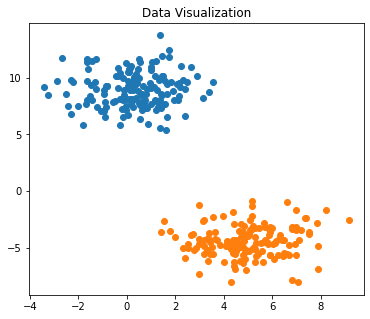

In [19]:
X, y = make_blobs(n_samples=300, n_features=2, cluster_std=1.5, centers=2, random_state=23)

plot_data(X, y)

Применим к этой задаче алгоритм "решающий пень":

In [20]:
some_tree = ClassificationDecisionTree(max_depth=1, min_leaf_size=1)
some_tree.fit(X, y);

Если вы всё реализовали правильно, то должно получиться что-то такое:

Accuracy = 1.0


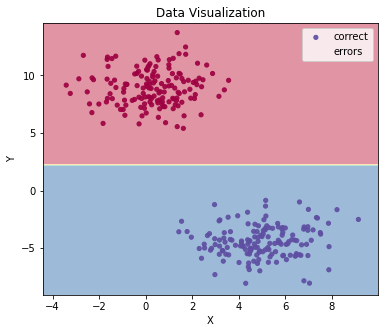

In [21]:
plot_decision_surface(some_tree, X, y)

Теперь рассмотрим более сложную задачу с плохо разделимыми классами:

In [22]:
X, y = make_blobs(n_samples=300, n_features=2, cluster_std=2, centers=5, random_state=23)

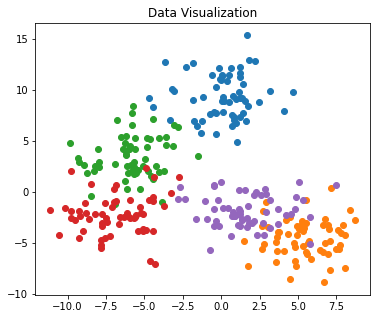

In [23]:
plot_data(X, y)

Посмотрим на результаты, которые получаются при разных значениях глубины:

Accuracy = 0.4


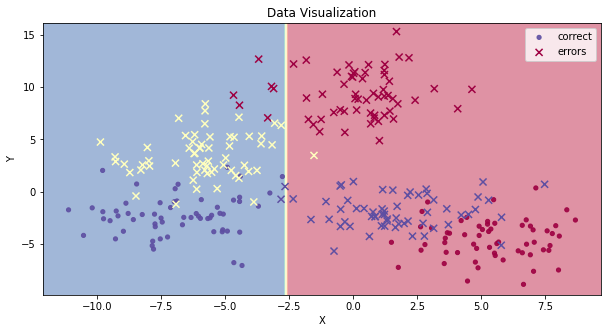

In [24]:
some_tree = ClassificationDecisionTree(max_depth=1, min_leaf_size=1)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

Accuracy = 0.747


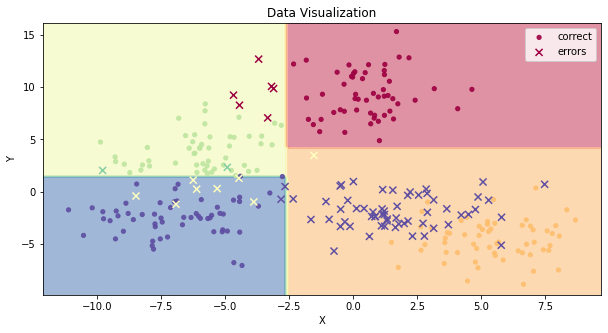

In [25]:
some_tree = ClassificationDecisionTree(max_depth=2, min_leaf_size=1)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

Accuracy = 0.89


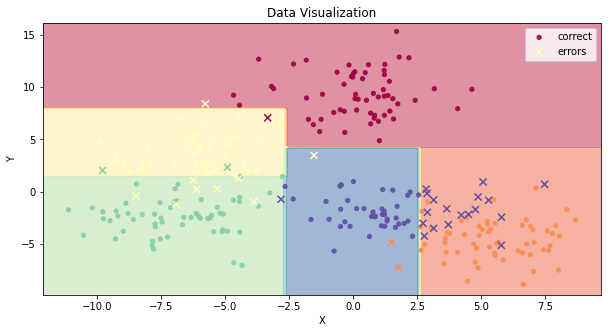

In [26]:
some_tree = ClassificationDecisionTree(max_depth=3, min_leaf_size=1)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

Accuracy = 0.94


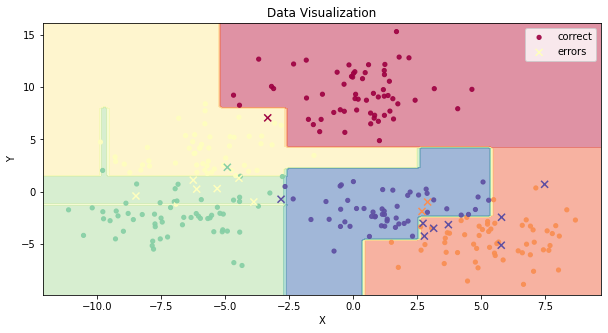

In [27]:
some_tree = ClassificationDecisionTree(max_depth=5, min_leaf_size=1)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

Accuracy = 1.0


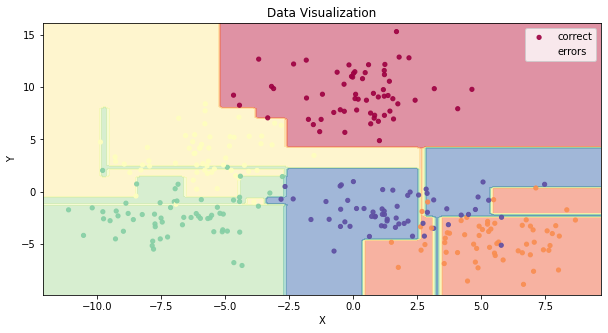

In [28]:
some_tree = ClassificationDecisionTree(max_depth=10, min_leaf_size=1)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

Можно заметить, что начиная с некоторого значения глубины, дерево начинает сильно переобучаться (новые сплиты пытаются описать максимум 1-2 объекта). Это можно поправить, изменяя параметр `min_leaf_size` или `min_improvement`.

Accuracy = 0.95


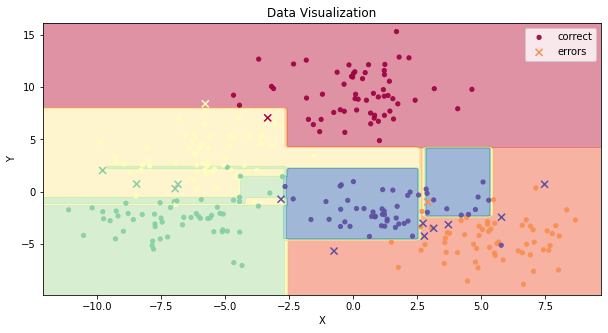

In [29]:
some_tree = ClassificationDecisionTree(max_depth=10, min_leaf_size=10)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

Accuracy = 1.0


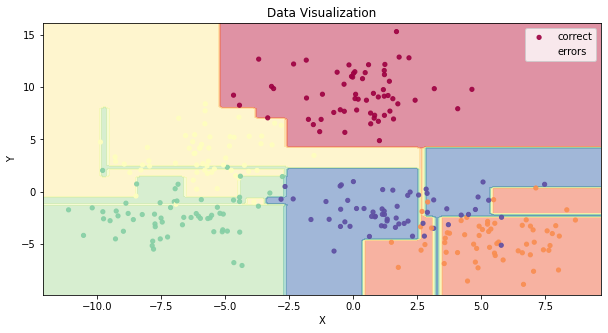

In [30]:
some_tree = ClassificationDecisionTree(max_depth=10, min_improvement=0.08)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

**3. (2 балла) Реализуйте регрессионное дерево. В качестве критерия необходимо использовать критерий, определённый в пункте 2. В качестве функции выдачи результатов необходимо использовать среднее значение ответов по всем объектам в листе.**


In [31]:
class RegressionDecisionTree(DecisionTree):
    def __init__(self, criterion='mse', **kwargs):
        super().__init__(**kwargs)
        
        if criterion not in ('mse', ):
            raise ValueError('Unsupported criterion', criterion)
        self.criterion = criterion
         
    def fit(self, X, y):
        self.n_features = X.shape[1]
        
        if self.criterion == 'mse':
            criterion = MSECriterion()
        else:
            raise ValueError('Unsupported criterion', criterion)

        self.root_ = TreeNode.from_criterion(y, criterion)
        self._build_nodes(X, y, criterion, np.arange(X.shape[0]), self.root_)
        
        return self
    
    def predict(self, X):
        pred_values = np.zeros(shape=(X.shape[0]))
        self._get_nodes_predictions(X, pred_values, np.arange(X.shape[0]), self.root_)
        return pred_values


-    **Сгенерируйте однопризнаковую выборку для тестирования дерева и покажите работу дерева на этой выборке. Отобразите на одном графике значения алгоритма и точки. Нарисуйте эту картинку для нескольких значений глубины. Сделайте выводы.**

In [32]:
X, y = make_regression(n_samples=10000, n_features=1, random_state=42)

In [33]:
def scatter_dy_depth(X, y, max_tree_depth=1, min_leaf_size=1, cmap='Spectral', figsize=(6, 5)):
    rgr = RegressionDecisionTree(max_depth=max_tree_depth, min_leaf_size=min_leaf_size)
    rgr.fit(X, y)
    y_pred = rgr.predict(X)
    
    # Plot the scatterplot with initial data and predicted values
    plt.figure(figsize=figsize)
    plt.scatter(X, y_pred, c='red', alpha=0.2, linewidths=5)
    plt.scatter(X, y, c='blue', alpha=0.2)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis("tight")
    plt.legend(['predicted', 'initial'], loc='best')
    print("MSE =", round(mean_squared_error(y, y_pred), 3))
    plt.title(f'Data Visualization for depth = {max_tree_depth}')
    plt.show()

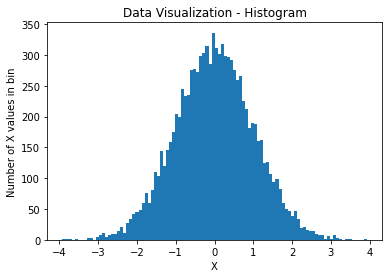

In [34]:
plt.hist(X, bins=100)
plt.xlabel('X')
plt.ylabel('Number of X values in bin')
plt.title(f'Data Visualization - Histogram');

У нас 10000 объектов. Количество листьев (с учетом показателя min_leaf_size=1) будет равно 2**(depth)

Тогда чтобы каждое значение попало в отдельный лист, необходимо, чтобы глубина дерева была не меньше $np.log(10000) = 13.29$

In [35]:
np.log2(10000)

13.287712379549449

Проверим все значения глубины дерева от 1 до 14 и выведем MSE для моделей

MSE = 379.398


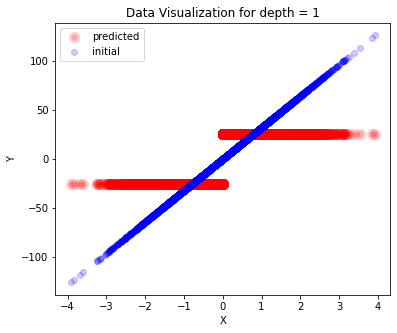

MSE = 122.618


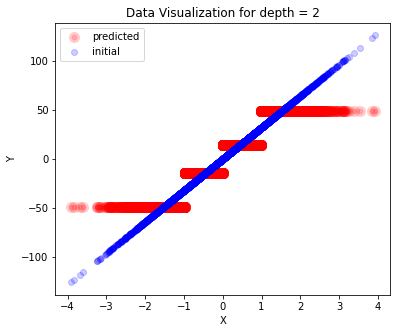

MSE = 36.714


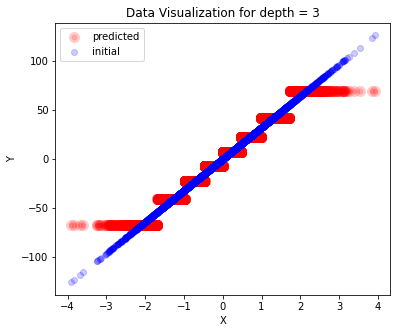

MSE = 10.097


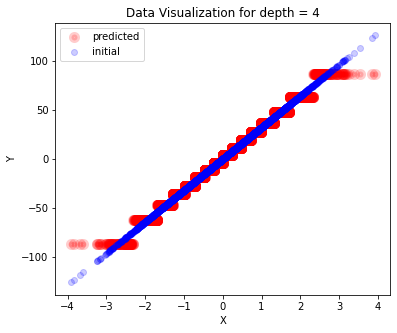

MSE = 2.736


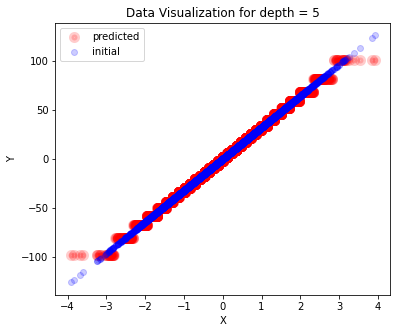

MSE = 0.679


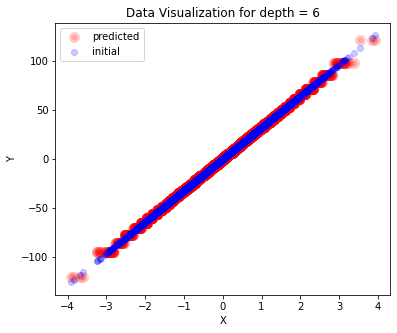

MSE = 0.163


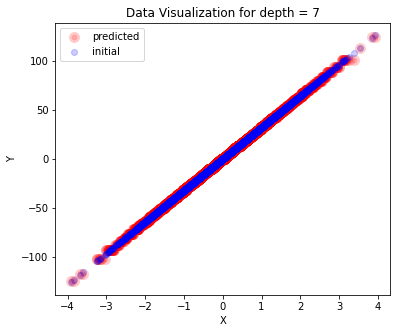

MSE = 0.041


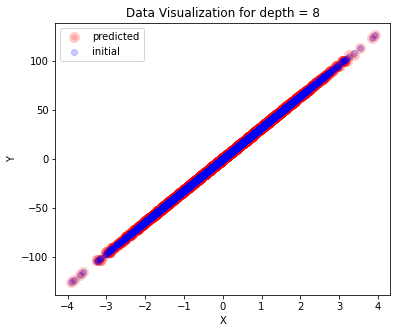

MSE = 0.009


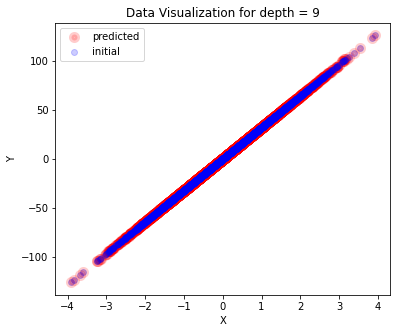

MSE = 0.002


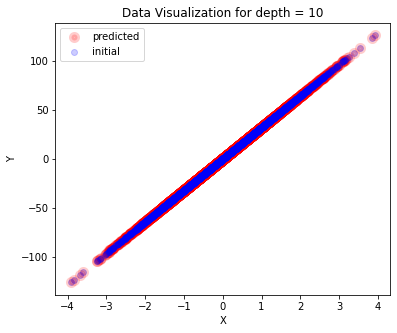

MSE = 0.0


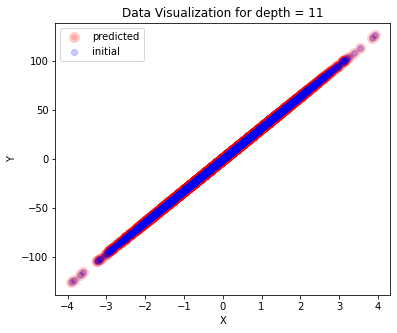

MSE = 0.0


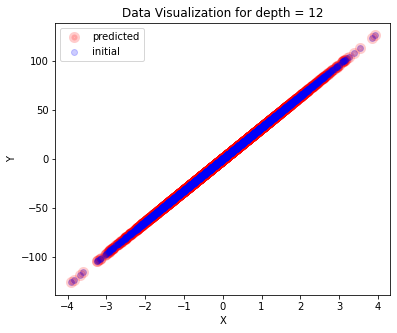

MSE = 0.0


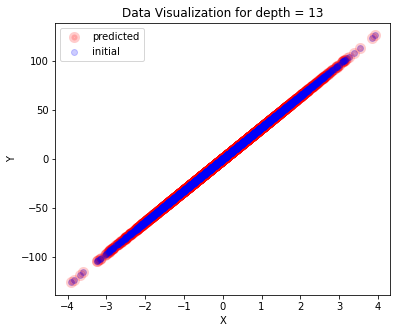

MSE = 0.0


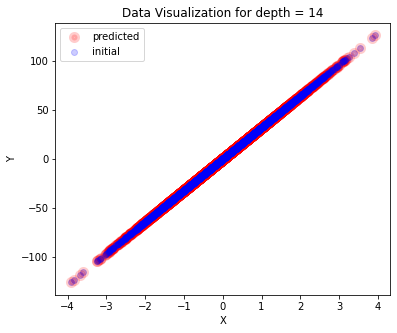

In [36]:
for depth in range(1, 15):
    scatter_dy_depth(X, y, max_tree_depth=depth);

**Вывод.** Для глубины дерева = 1 мы получили одно значение, по которому поделена выборка. Поэтому предсказания могут принимать всего два значения. По мере увеличения глубины количество значений предсказаний увеличивается экспоненциально. Для полного переобучения в случае 10 тысяч объектов достаточно глубины дерева, равной 14. При округлении ошибки MSE (на основе которой в том числе было построено дерево) до 3 знаков после запятой, оказалось дочтаточно глубины = 11, хотя при глубине 7 и 8 ошибки уже были подозрительно малыми.

Так как единственный признак взят из нормального распределения, заметно, что каждая ступенька "прижата" ближе к середине отрезка по Y, и сами отрезки расположены симметрично (что тем более заметно, чем большая выборка будет взята), а наибольший вклад в ошибку вносят те значения, что лежат дальше наружу от среднего (здесь равного 0). Это заметно по самым нижним/ верхним "ступенькам" - они всегда самые длинные среди всех "ступенек". И это еще раз напоминает о том, что для признака со значениями, распределенными нормально, именно значения, рассчитанные как 1.5 межкварильных размаха от 1 и 3 квартилей (которые принято называть выбросами), действительно больше других влияют на точность. 

**4. (2 балла) Протестируйте ваше дерево на california_housing датасете (можно загрузить с помощью sklearn.datasets.fetch_california_housing).
    Разбейте данные на обучение, контроль и тест.**


In [37]:
print(fetch_california_housing(as_frame=True).DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [38]:
X, y = fetch_california_housing(return_X_y=True, as_frame=True)

In [39]:
# проверим что нет пропущенных значений

X.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


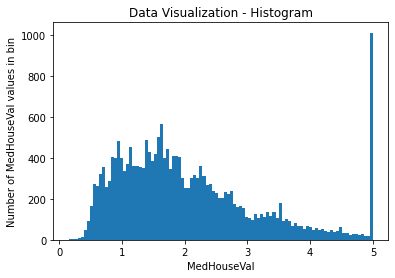

In [40]:
plt.hist(y, bins=100)
plt.xlabel(f'{y.name}')
plt.ylabel(f'Number of {y.name} values in bin')
plt.title(f'Data Visualization - Histogram');

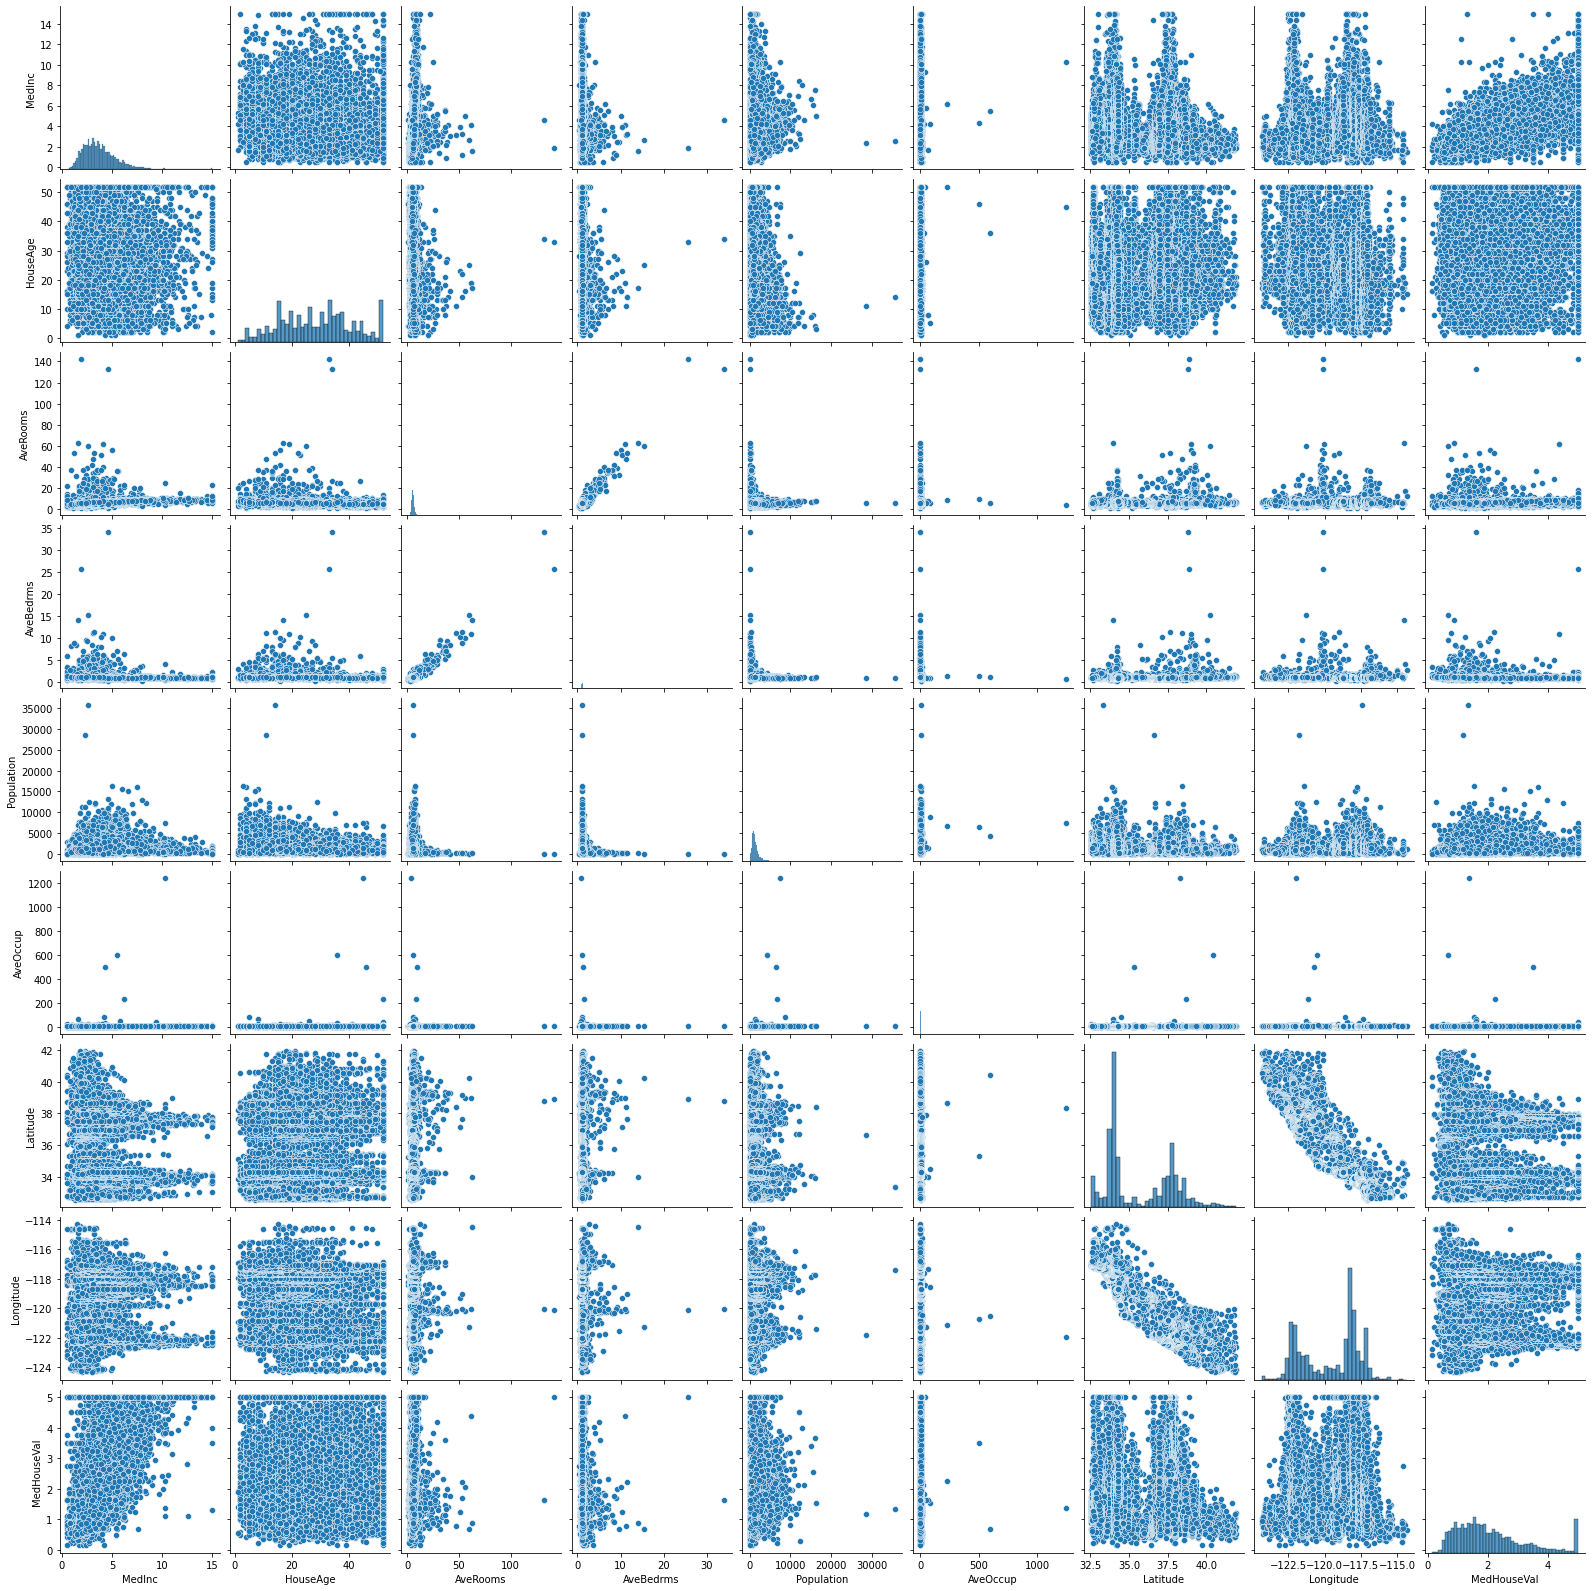

In [41]:
sns.pairplot(pd.concat([X, y], axis=1))

Видно, что есть коррелирующие признаки, признаки с выбросами, бимодальные признакми, и что у целевой переменной есть "потолок".

Вполне возможно что дерево как раз хорошо отработает на таких данных, так как выбросы сразу уйдут в отдельный лист, и бимодальность тоже хорошо поделится.

In [42]:
# делим выборку на валидационную, тестовую и обучающую

X_train_, X_test, y_train_, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_, y_train_, test_size=0.2, random_state=42)

**Подберите гиперпараметры по контрольной выборке, покажите качество алгоритма на тестовой. Сделайте выводы.**

In [43]:
len(X_train) / 2**6

206.390625

Исходя из предыдущего задания, будем ориентироваться на глубину = 6. Начнем с 2.

Как мы выяснили выше, можно перебирать либо количество объектов в листе, либо минимальное улучшение после разбиения. Будем смотреть на min_leaf_size.

Посчитаем количество объектов в листе следующим образом. Для симметричного дерева для каждой глубины мы бы получили 2^(depth) листьев, а значит в каждом листе было бы от 206 объектов. Но у нас практически нет идеально нормально распределенных признаков, поэтому количество листьев будет меньше, и соответственно будут листья, в которых количество объектов будет еще меньше 206. На построенном pairplot мы видим, что выбросов немного - 2-4 штуки (если нет наложений). Будем перебирать от 2 до 20 с шагом 2.

In [49]:
best_params = {'max_depth':0, 'min_leaf_size':0, 'MSE':1e9}

for depth in range(2, 10):
    for leaf in tqdm(range(2, 20, 2)):
        rgr = RegressionDecisionTree(max_depth=depth, min_leaf_size=leaf)
        rgr.fit(X_train.values, y_train.values)
        cur_y_pred = rgr.predict(X_val.values)
        cur_MSE = mean_squared_error(y_val.values, cur_y_pred)
        if best_params['MSE'] > cur_MSE:
            best_params['max_depth'] = depth
            best_params['min_leaf_size'] = leaf
            best_params['MSE'] = cur_MSE
            print(f"""New best parameters: max_depth = {depth}, min_leaf_size = {leaf}, MSE = {cur_MSE}""")

 11%|███████████▏                                                                                         | 1/9 [00:10<01:20, 10.05s/it]

New best parameters: max_depth = 2, min_leaf_size = 2, MSE = 0.7650860967056791


 11%|███████████▏                                                                                         | 1/9 [00:14<01:54, 14.26s/it]

New best parameters: max_depth = 3, min_leaf_size = 2, MSE = 0.6559400430863094


 11%|███████████▏                                                                                         | 1/9 [00:18<02:27, 18.44s/it]

New best parameters: max_depth = 4, min_leaf_size = 2, MSE = 0.5973057157444469


 11%|███████████▏                                                                                         | 1/9 [00:22<03:02, 22.82s/it]

New best parameters: max_depth = 5, min_leaf_size = 2, MSE = 0.5538113550117661


 44%|████████████████████████████████████████████▉                                                        | 4/9 [01:29<01:51, 22.20s/it]

New best parameters: max_depth = 5, min_leaf_size = 8, MSE = 0.5528857881159198


 11%|███████████▏                                                                                         | 1/9 [00:24<03:16, 24.57s/it]

New best parameters: max_depth = 6, min_leaf_size = 2, MSE = 0.5148409681223435


 22%|██████████████████████▍                                                                              | 2/9 [00:49<02:52, 24.68s/it]

New best parameters: max_depth = 6, min_leaf_size = 4, MSE = 0.5147520369823024


 33%|█████████████████████████████████▋                                                                   | 3/9 [01:13<02:27, 24.65s/it]

New best parameters: max_depth = 6, min_leaf_size = 6, MSE = 0.5136320651309438


 44%|████████████████████████████████████████████▉                                                        | 4/9 [01:38<02:03, 24.68s/it]

New best parameters: max_depth = 6, min_leaf_size = 8, MSE = 0.5127064982350975


 11%|███████████▏                                                                                         | 1/9 [00:28<03:45, 28.20s/it]

New best parameters: max_depth = 7, min_leaf_size = 2, MSE = 0.48307498635182783


 22%|██████████████████████▍                                                                              | 2/9 [00:56<03:17, 28.17s/it]

New best parameters: max_depth = 7, min_leaf_size = 4, MSE = 0.48298605521178684


 33%|█████████████████████████████████▋                                                                   | 3/9 [01:24<02:49, 28.24s/it]

New best parameters: max_depth = 7, min_leaf_size = 6, MSE = 0.48267597114342004


 44%|████████████████████████████████████████████▉                                                        | 4/9 [01:52<02:20, 28.08s/it]

New best parameters: max_depth = 7, min_leaf_size = 8, MSE = 0.48178391319532476


 56%|████████████████████████████████████████████████████████                                             | 5/9 [02:20<01:51, 27.93s/it]

New best parameters: max_depth = 7, min_leaf_size = 10, MSE = 0.4817076165993406


  0%|                                                                                                             | 0/9 [00:00<?, ?it/s]/home/uliana/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/uliana/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 11%|███████████▏                                                                                         | 1/9 [00:31<04:13, 31.67s/it]

New best parameters: max_depth = 8, min_leaf_size = 2, MSE = 0.47459073404061586


/home/uliana/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/uliana/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 22%|██████████████████████▍                                                                              | 2/9 [01:02<03:39, 31.42s/it]

New best parameters: max_depth = 8, min_leaf_size = 4, MSE = 0.4744399396028994


/home/uliana/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/uliana/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 33%|█████████████████████████████████▋                                                                   | 3/9 [01:34<03:07, 31.33s/it]

New best parameters: max_depth = 8, min_leaf_size = 6, MSE = 0.4743479889021802


/home/uliana/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/uliana/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 44%|████████████████████████████████████████████▉                                                        | 4/9 [02:05<02:35, 31.15s/it]

New best parameters: max_depth = 8, min_leaf_size = 8, MSE = 0.4711999059861804


/home/uliana/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/uliana/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 56%|████████████████████████████████████████████████████████                                             | 5/9 [02:36<02:04, 31.09s/it]

New best parameters: max_depth = 8, min_leaf_size = 10, MSE = 0.46262497061708113


/home/uliana/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/uliana/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 67%|███████████████████████████████████████████████████████████████████▎                                 | 6/9 [03:06<01:33, 31.01s/it]

New best parameters: max_depth = 8, min_leaf_size = 12, MSE = 0.4618898493141704


/home/uliana/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/uliana/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 78%|██████████████████████████████████████████████████████████████████████████████▌                      | 7/9 [03:38<01:02, 31.07s/it]/home/uliana/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/uliana/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 89%|█████████████████████████████████████████████████████████████████████████████████████████▊           | 8/9 [04:09<00:31, 31.06s/it]/home/uliana/anaconda3/lib/python3

New best parameters: max_depth = 9, min_leaf_size = 8, MSE = 0.4541239632590197


/home/uliana/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/uliana/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 56%|████████████████████████████████████████████████████████                                             | 5/9 [02:56<02:21, 35.49s/it]

New best parameters: max_depth = 9, min_leaf_size = 10, MSE = 0.44203713519502386


/home/uliana/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/uliana/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 67%|███████████████████████████████████████████████████████████████████▎                                 | 6/9 [03:30<01:45, 35.11s/it]/home/uliana/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/uliana/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 78%|██████████████████████████████████████████████████████████████████████████████▌                      | 7/9 [04:05<01:09, 34.90s/it]/home/uliana/anaconda3/lib/python3

New best parameters: max_depth = 9, min_leaf_size = 16, MSE = 0.44011421195652434


/home/uliana/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/uliana/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [05:16<00:00, 35.12s/it]


Можно было бы докрутить параметры (увеличить глубину и минимальное количество объектов в листе), но у нас уже появляется предупреждение о возможном появлении слишком больших чисел. Тогда нужно либо изменять метрику (например, логарифмировать), либо считать в таких типах данных, которые допускают более значительные порядки чисел. В принципе, мы уже получили достаточно хороший результат. Так что остановимся на гиперпараметрах max_depth = 9, min_leaf_size = 16.

**Проверим качество на тестовой выборке.**

In [52]:
rgr = RegressionDecisionTree(max_depth=best_params['max_depth'], min_leaf_size=best_params['min_leaf_size'])
rgr.fit(X_train.values, y_train.values)
y_pred = rgr.predict(X_test.values)
MSE = np.sum((y_test.values - y_pred) ** 2) / y_pred.size

/home/uliana/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/uliana/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [61]:
y_pred[np.isnan(y_pred)]

array([nan, nan])

Собственно, именно с этой ошибкой мы и столкнулись при попытке проверить модель на тестовой выборке.
Возьмем те предыдущие значения лучших параметров, где этой ошибки не было.

In [66]:
max_depth = 7
min_leaf_size = 10

In [67]:
rgr = RegressionDecisionTree(max_depth=max_depth, min_leaf_size=min_leaf_size)
rgr.fit(X_train.values, y_train.values)
y_pred = rgr.predict(X_test.values)
MSE = np.sum((y_test.values - y_pred) ** 2) / y_pred.size

In [70]:
print(f'MSE_validation = 0.482, MSE_test = {round(MSE, 3)}')

MSE_validation = 0.482, MSE_test = 0.475


Таким образом, подбор параметров с учетом валидационной выборки сработал очень хорошо и для такого разбиения на тестовую, валидационную и обущающую выборки позвоолил получить качество на тестовой выборке, сравнимое с качеством на валидации.